Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa
import math

Define constant values

In [2]:
SAMPLE_RATE = 22050
SONG_DURATION = 30
DATASET_PATH = 'data'
SAMPLES_PER_SONG = SONG_DURATION * SAMPLE_RATE
NUMBER_OF_SEGMENTS = 5

Load dataset function

In [5]:
def load_dataset(dataset_path, n_fft, hop_length, n_mfcc, number_of_segments):
    
    samples_per_segment = int(SAMPLES_PER_SONG / number_of_segments)
    mfcc_length = math.ceil(samples_per_segment / hop_length)

    dataset = {"data": [], "label": []}

    # Load dataset
    for root, dirs, files in os.walk(dataset_path):
        for file in files:

            # Load signal from file
            file_path = os.path.join(root, file)
            signal, sample_rate = librosa.load(file_path)

            # Get label
            label = file.split(".")[0]

            # Cut signal on segments
            for i in range(number_of_segments):

                # Calculate start and end of segment
                start = samples_per_segment * i
                end = start + samples_per_segment

                # Get mfcc for segment
                segment = signal[start:end]
                mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate, hop_length=hop_length, n_fft=n_fft, n_mfcc=n_mfcc)
                mfcc = mfcc.T
                
                # Add segment mfcc to dataset if segment has correct length
                if len(mfcc) == mfcc_length:
                    dataset['data'].append(mfcc.tolist())
                    dataset['label'].append(label)
                    print(f'{file}/{i}')

    return dataset

In [6]:
dataset = load_dataset(DATASET_PATH, 2048, 512, 13, 5)

blues.00000.wav/0
blues.00000.wav/1
blues.00000.wav/2
blues.00000.wav/3
blues.00000.wav/4
blues.00001.wav/0
blues.00001.wav/1
blues.00001.wav/2
blues.00001.wav/3
blues.00001.wav/4
blues.00002.wav/0
blues.00002.wav/1
blues.00002.wav/2
blues.00002.wav/3
blues.00002.wav/4
blues.00003.wav/0
blues.00003.wav/1
blues.00003.wav/2
blues.00003.wav/3
blues.00003.wav/4
blues.00004.wav/0
blues.00004.wav/1
blues.00004.wav/2
blues.00004.wav/3
blues.00004.wav/4
blues.00005.wav/0
blues.00005.wav/1
blues.00005.wav/2
blues.00005.wav/3
blues.00005.wav/4
blues.00006.wav/0
blues.00006.wav/1
blues.00006.wav/2
blues.00006.wav/3
blues.00006.wav/4
blues.00007.wav/0
blues.00007.wav/1
blues.00007.wav/2
blues.00007.wav/3
blues.00007.wav/4
blues.00008.wav/0
blues.00008.wav/1
blues.00008.wav/2
blues.00008.wav/3
blues.00008.wav/4
blues.00009.wav/0
blues.00009.wav/1
blues.00009.wav/2
blues.00009.wav/3
blues.00009.wav/4
blues.00010.wav/0
blues.00010.wav/1
blues.00010.wav/2
blues.00010.wav/3
blues.00010.wav/4
blues.0001

Prepare dataset

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

X = np.array(dataset['data'])
y = np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)


In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [50]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [51]:
import keras
from keras.layers import LSTM, Dropout, Dense, BatchNormalization

input_shape = (len(X_train[0]), len(X_train[0][0]))

model = keras.Sequential()

model.add(LSTM(128,input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               72704     
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)               

In [52]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    verbose=1
)

Epoch 1/100
28/28 [==============================] - 24s 494ms/step - loss: 2.9533 - accuracy: 0.1348 - val_loss: 2.2033 - val_accuracy: 0.2497
Epoch 2/100
28/28 [==============================] - 12s 445ms/step - loss: 2.5706 - accuracy: 0.1840 - val_loss: 2.1184 - val_accuracy: 0.2850
Epoch 3/100
28/28 [==============================] - 13s 446ms/step - loss: 2.3892 - accuracy: 0.2169 - val_loss: 2.0325 - val_accuracy: 0.2951
Epoch 4/100
28/28 [==============================] - 13s 462ms/step - loss: 2.2467 - accuracy: 0.2395 - val_loss: 1.9746 - val_accuracy: 0.3171
Epoch 5/100
28/28 [==============================] - 13s 468ms/step - loss: 2.1404 - accuracy: 0.2589 - val_loss: 1.9022 - val_accuracy: 0.3531
Epoch 6/100
28/28 [==============================] - 12s 447ms/step - loss: 2.0609 - accuracy: 0.2753 - val_loss: 1.8450 - val_accuracy: 0.3491
Epoch 7/100
28/28 [==============================] - 13s 457ms/step - loss: 1.9880 - accuracy: 0.2956 - val_loss: 1.7760 - val_accuracy:

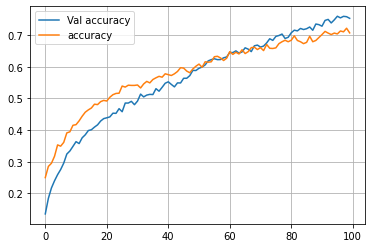

In [62]:
plt.plot(history.history['accuracy'], label="Val accuracy")
plt.plot(history.history['val_accuracy'], label="accuracy")
plt.legend()
plt.grid()
plt.show()